In [32]:
import subprocess
import pandas as pd
import os
from datetime import datetime
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

# downloading and updating data

exclude = {"transform_universal.py"}

scripts_dir = os.getcwd()

scripts = sorted(
    f for f in os.listdir(scripts_dir)
    if f.endswith(".py") and f not in exclude
)

for f in scripts:
    print(f"Running: {f}")
    subprocess.run([sys.executable, f], cwd=scripts_dir, check=True)

print("All scripts finished.")



Running: download_static.py
Running: transform_calendar_calendar_dates.py
Running: transform_routes.py
Running: transform_stop_times.py
Running: transform_stops.py
Running: transform_transfers.py
Running: transform_trips.py
All scripts finished.


In [33]:
# loading csv files

data = {}
for name in ["stops_processed.csv", "routes_processed.csv", "trips_processed.csv", "stop_times_processed.csv", "calendar_processed.csv", "calendar_dates_processed.csv", "transfers_processed.csv"]:
    df = pd.read_csv(os.path.join("data/processed",name),low_memory=False)
    name = name[:-4]
    data[name] = df

# setting up dataframes

stops_df          = data["stops_processed"]
routes_df         = data["routes_processed"]
trips_df          = data["trips_processed"]
stop_times_df     = data["stop_times_processed"]
calendar_df       = data["calendar_processed"]
calendar_dates_df = data["calendar_dates_processed"]
transfers_df      = data["transfers_processed"]

# merging dataframes

route_type_df     = routes_df[["route_type", "route_id"]]
route_type_df     = pd.merge(route_type_df, trips_df[['route_id', 'trip_id']], on='route_id')
route_type_df     = pd.merge(route_type_df, stop_times_df[['stop_id', 'trip_id']], on='trip_id')
route_type_df     = pd.merge(route_type_df, stops_df[['stop_id', 'stop_name']], on='stop_id')
trips_trans       = pd.merge(trips_df, routes_df[["route_type", "route_id"]], on = "route_id")
stop_times_trans  = pd.merge(stop_times_df, trips_trans[["route_type", "trip_id"]], on = "trip_id")
stop_trans        = pd.merge(stops_df, stop_times_trans[["route_type", "stop_id"]], on = "stop_id")



## HIGHEST VISIBILITY


In [34]:
def compute_high_visibility(stop_times_df, stops_df):

    trips_count = stop_times_df.groupby('stop_id')['trip_id'].nunique().reset_index()
    
    high_visibility = stops_df[['stop_id', 'stop_name']]
    high_visibility = pd.merge(high_visibility, trips_count, on='stop_id', how='left')
    
    high_visibility = (high_visibility.groupby('stop_name', as_index=False)['trip_id'].sum().sort_values('trip_id', ascending=False).reset_index(drop=True))
    
    return high_visibility

In [35]:
high_visibility = compute_high_visibility(stop_times_df, stops_df)
high_visibility.head(10)

,stop_name,trip_id
0,Želivského,8203.0
1,Anděl,7714.0
2,Smíchovské nádraží,7482.0
3,Palmovka,7066.0
4,Lihovar,6387.0
5,Kobylisy,5945.0
6,Malostranská,5800.0
7,Karlovo náměstí,5799.0
8,Černý Most,5769.0
9,Hradčanská,5556.0


## LONGEST EXPOSURE

### 1. Sorting routes by longest duration

In [36]:
def time_to_seconds(t):
    h, m, s = map(int, t.split(':'))
    return h*3600 + m*60 + s

In [37]:
def get_first_arrival_seconds(stop_times_df):

    first_rows = stop_times_df.loc[stop_times_df.groupby('trip_id')['arrival_time'].idxmin()]
    first_rows = first_rows[['trip_id', 'arrival_time']].copy()
    first_rows['arrival_seconds'] = first_rows['arrival_time'].apply(time_to_seconds)
    return first_rows


def get_last_arrival_seconds(stop_times_df):

    last_rows = stop_times_df.loc[stop_times_df.groupby('trip_id')['arrival_time'].idxmax()]
    last_rows = last_rows[['trip_id', 'arrival_time']].copy()
    last_rows['arrival_seconds'] = last_rows['arrival_time'].apply(time_to_seconds)
    return last_rows

In [38]:
def compute_trip_durations(first_arrivals, last_arrivals):

    duration_series = last_arrivals.set_index('trip_id')['arrival_seconds'] - \
                      first_arrivals.set_index('trip_id')['arrival_seconds']
    duration_df = duration_series.reset_index()
    duration_df = duration_df.rename(columns={'arrival_seconds': 'duration_seconds'})
    return duration_df

In [39]:
class RouteDurationAnalyzer:
    
    # computing route duration + optionally filtering out regional routes

    def __init__(self, stop_times_df, trips_df, routes_df):
        self.stop_times_df = stop_times_df
        self.trips_df = trips_df
        self.routes_df = routes_df

    def compute_avg_duration_per_route(self, exclude_regional=True):

        first_arrivals = get_first_arrival_seconds(self.stop_times_df)
        last_arrivals = get_last_arrival_seconds(self.stop_times_df)

        # computing durations per trip
        duration_df = compute_trip_durations(first_arrivals, last_arrivals)

        duration_df = pd.merge(duration_df, self.trips_df[['trip_id', 'route_id']], on='trip_id')

        # computing average duration per route
        avg_duration_per_route = duration_df.groupby('route_id')['duration_seconds'].mean().reset_index()

        # converting average to minutes
        avg_duration_per_route['duration_minutes'] = round(avg_duration_per_route['duration_seconds'] / 60, 0)

        avg_duration_per_route = pd.merge(
            avg_duration_per_route,
            self.routes_df[['route_short_name', 'route_id', 'is_regional']],
            on='route_id'
        )

        # optionally excluding regional routes
        if exclude_regional:
            avg_duration_per_route = avg_duration_per_route[avg_duration_per_route['is_regional'] != 1]

        # sorting descending based on duration
        avg_duration_per_route = avg_duration_per_route.sort_values(by='duration_seconds', ascending=False).reset_index(drop=True)

        avg_duration_per_route = avg_duration_per_route[
            [
                'route_id',
                'route_short_name',
                'is_regional',
                'duration_seconds',
                'duration_minutes'
            ]
        ]
        
        return avg_duration_per_route

In [40]:
analyzer = RouteDurationAnalyzer(stop_times_df, trips_df, routes_df)

# computing average duration per route in minutes + excluding regional routes
avg_duration_routes = analyzer.compute_avg_duration_per_route()

avg_duration_routes.head(10)

,route_id,route_short_name,is_regional,duration_seconds,duration_minutes
0,L911,911,0,4648.888889,77.0
1,L910,910,0,4374.000000,73.0
2,L95,95,0,4303.333333,72.0
3,L136,136,0,4185.159574,70.0
4,L908,908,0,4166.250000,69.0
5,L913,913,0,4164.000000,69.0
6,L904,904,0,4092.000000,68.0
7,L166,166,0,3941.111111,66.0
8,L907,907,0,3881.052632,65.0
9,L97,97,0,3832.173913,64.0


### 2. Sorting routes by highest amounts of stops

In [41]:
def compute_avg_stops_per_route(stop_times_df, trips_df, routes_df, exclude_regional=True):

    # counting number of stops per trip

    stops_counts = (
        stop_times_df
        .groupby('trip_id')['stop_id']
        .count()
        .reset_index(name='num_stops')
    )

    # getting route_id from trips_df

    stops_counts = pd.merge(
        stops_counts,
        trips_df[['trip_id', 'route_id']],
        on='trip_id'
    )

    # computing average stops per route
    avg_stops_per_route = (
        stops_counts
        .groupby('route_id')['num_stops']
        .mean()
        .round(0)
        .reset_index()
    )
   
    avg_stops_per_route = pd.merge(
        avg_stops_per_route,
        routes_df[['route_id', 'route_short_name', 'is_regional']],
        on='route_id'
    )

    # optionally excluding regional routes
    if exclude_regional:
        avg_stops_per_route = avg_stops_per_route.loc[
            avg_stops_per_route['is_regional'] != 1
        ]

    # sorting descending by number of stops
    avg_stops_per_route = avg_stops_per_route.sort_values(
        by='num_stops',
        ascending=False
    ).reset_index(drop=True)

    return avg_stops_per_route


In [42]:
# calculating average stops per route

avg_stops_per_route = compute_avg_stops_per_route(
    stop_times_df,
    trips_df,
    routes_df
)

avg_stops_per_route.head(10)

,route_id,num_stops,route_short_name,is_regional
0,L908,60.0,908,0
1,L910,58.0,910,0
2,L911,54.0,911,0
3,L913,52.0,913,0
4,L95,51.0,95,0
5,L904,50.0,904,0
6,L166,49.0,166,0
7,L914,47.0,914,0
8,L154,46.0,154,0
9,L905,46.0,905,0


## HIGHEST REPETITION

In [43]:
def compute_route_repetition(trips_df, routes_df, exclude_regional=True):

    # counting unique trips per route
    repetition = (
        trips_df
        .groupby('route_id')['trip_id']
        .nunique()
        .reset_index(name='trip_count')
    )

    high_repetition = pd.merge(
        routes_df[['route_id', 'route_short_name', 'is_regional']],
        repetition,
        on='route_id'
    )

    # optionally excluding regional routes
    if exclude_regional:
        high_repetition = high_repetition.loc[
            high_repetition['is_regional'] != 1
        ]

    # sorting descending by trip count
    high_repetition = high_repetition.sort_values(
        by='trip_count',
        ascending=False
    ).reset_index(drop=True)

    return high_repetition

In [44]:
high_repetition = compute_route_repetition(trips_df, routes_df)
high_repetition.head(10)

,route_id,route_short_name,is_regional,trip_count
0,L991,A,0,1716
1,L993,C,0,1022
2,L992,B,0,969
3,L812,X12,0,954
4,L20,20,0,801
5,L22,22,0,771
6,L12,12,0,748
7,L17,17,0,717
8,L5,5,0,712
9,L59,59,0,708


In [45]:

all_df = stop_times_df[["trip_id", "stop_id"]]

all_df = all_df.merge(stops_df[["stop_name", "stop_id"]], on = "stop_id")

all_df = all_df.merge(trips_df[["trip_id", "route_id"]], on = "trip_id")

all_df = all_df.merge(routes_df[["route_id", "route_type"]], on = "route_id")

all_df.head(5)

,trip_id,stop_id,stop_name,route_id,route_type
0,991_9400_250901,U953Z102P,Skalka,L991,1
1,991_9400_250901,U713Z102P,Strašnická,L991,1
2,991_9400_250901,U921Z102P,Želivského,L991,1
3,991_9400_250901,U118Z102P,Flora,L991,1
4,991_9400_250901,U209Z102P,Jiřího z Poděbrad,L991,1


In [46]:
stop_type = all_df[['stop_name', "route_type"]].copy()

stop_type["metro"] = (stop_type['route_type'] == 1).astype(int)

stop_type["tram"] = (stop_type['route_type'] == 0).astype(int)

stop_type["bus"] = (stop_type['route_type'] == 3).astype(int)

stop_type["train"] = (stop_type['route_type'] == 2).astype(int)

stop_type["trolley"] = (stop_type['route_type'] == 11).astype(int)

stop_type["ferry"] = (stop_type['route_type'] == 4).astype(int)

stop_type.head()

,stop_name,route_type,metro,tram,bus,train,trolley,ferry
0,Skalka,1,1,0,0,0,0,0
1,Strašnická,1,1,0,0,0,0,0
2,Želivského,1,1,0,0,0,0,0
3,Flora,1,1,0,0,0,0,0
4,Jiřího z Poděbrad,1,1,0,0,0,0,0


In [47]:
stop_type = stop_type.groupby('stop_name', as_index=False).agg({
    'metro': 'max',
    'tram': 'max',
    'bus': 'max',
    'train': 'max',
    'trolley': 'max',
    'ferry': 'max'
})

stop_type.head()

,stop_name,metro,tram,bus,train,trolley,ferry
0,AHr Dalešice,0,0,0,1,0,0
1,AHr Hlavačov náv. Lo,0,0,0,1,0,0
2,AHr Hlavačov náv. So,0,0,0,1,0,0
3,AHr Hřivno,0,0,0,1,0,0
4,AHr Merkovka,0,0,0,1,0,0


In [48]:
# defining conditions in order of priority
conditions = [
    stop_type['metro'] == 1,
    (stop_type['metro'] == 0) & (stop_type['tram'] == 1),
    (stop_type['metro'] == 0) & (stop_type['tram'] == 0) & (stop_type['bus'] == 1),
    (stop_type['metro'] == 0) & (stop_type['tram'] == 0) & (stop_type['bus'] == 0) & (stop_type['trolley'] == 1),
    (stop_type['metro'] == 0) & (stop_type['tram'] == 0) & (stop_type['bus'] == 0) & (stop_type['trolley'] == 0) & (stop_type['train'] == 1),
    (stop_type['metro'] == 0) & (stop_type['tram'] == 0) & (stop_type['bus'] == 0) & (stop_type['trolley'] == 0) & (stop_type['train'] == 0) & (stop_type['ferry'] == 1)
]

# corresponding values
values = [1, 2, 3, 4, 5, 6]

# creating new column
stop_type['type'] = np.select(conditions, values, default=np.nan)

In [49]:
metro_stops = stop_type.loc[stop_type['type'] == 1, 'stop_name'].tolist()
tram_stops = stop_type.loc[stop_type['type'] == 2, 'stop_name'].tolist()
bus_stops = stop_type.loc[stop_type['type'] == 3, 'stop_name'].tolist()
trolley_stops = stop_type.loc[stop_type['type'] == 4, 'stop_name'].tolist()

In [50]:
def get_stops_in_buffers(stops_df, main_loc=None, main_buffer_m=2000, 
                         other_locs_df=None, other_buffer_m=500):
    
    
    # some parameters explained:
    #   main_loc is a tuple with lon, lat for a single main location for city center
    #   main_buffer_m is a float with buffer radius in meters around main_loc
    #   other_locs_df is optional df and must have columns name, lon, lat
    #   other_buffer_m is a float with buffer radius in meters around other_locs_df

    # converting stops_df to geodataframe

    stops_gdf = gpd.GeoDataFrame(
        stops_df,
        geometry=gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat),
        crs="EPSG:4326"
    )

    # projecting to metric CRS for buffering (UTM 33N)
    stops_gdf = stops_gdf.to_crs(epsg=32633)

    buffers = []

    # main location buffer

    if main_loc is not None:
        lon, lat = main_loc
        main_point = gpd.GeoDataFrame(
            geometry=[Point(lon, lat)],
            crs="EPSG:4326"
        ).to_crs(epsg=32633)
        main_buffer = main_point.buffer(main_buffer_m)
        buffers.append(main_buffer.iloc[0])

    # other locations buffers

    if other_locs_df is not None and not other_locs_df.empty:
        other_gdf = gpd.GeoDataFrame(
            other_locs_df,
            geometry=gpd.points_from_xy(other_locs_df.lon, other_locs_df.lat),
            crs="EPSG:4326"
        ).to_crs(epsg=32633)

        other_gdf['buffer'] = other_gdf.geometry.buffer(other_buffer_m)
        buffers.append(other_gdf.set_geometry('buffer'))

    # finding stops inside main buffer

    stops_in_main = gpd.GeoDataFrame()
    if main_loc is not None:
        stops_in_main = stops_gdf[stops_gdf.within(buffers[0])]


    # finding stops inside other buffers

    stops_in_others = gpd.GeoDataFrame()
    if other_locs_df is not None and not other_locs_df.empty:
        stops_in_others = gpd.sjoin(
            stops_gdf,
            buffers[1][['name', 'buffer']],
            how='inner',
            predicate='within'
        )

    # combining results and dropping duplicates

    stops_near = pd.concat([stops_in_main, stops_in_others], ignore_index=True)
    stops_near = stops_near.drop_duplicates(subset='stop_id').reset_index(drop=True)

    return stops_near


In [51]:
# single central location (Prague center)
center = (14.420972919397157, 50.08765866076058)

# optional other locations
locations = pd.DataFrame({
    'name': ['StarNam', 'orloj', 'KarlMostA', 'KarlMostB', 
            "PraHradA", "PraHradB", "PraHradC", "svVit",
            "svMikul", "ZidCtvr", "Vacla", "PrasBran",
            "Petrin", "Strahov", "Kampa", "NarDiv",
            "TanDum", "Vysehrad", "hlnadr", "florenc",
            "letiste"],
    'lon': [14.421149945860101, 14.420747614525858, 14.4135452685722, 14.408962866055425, 
           14.398478111008016, 14.398403009161253, 14.405923923241033, 14.400130351854978,
           14.402694543646529, 14.42035420769547, 14.429763396936284, 14.428325982805555,
           14.395631969682988, 14.389473617716073, 14.407304943251118, 14.413420379781625, 
           14.41376370252825, 14.418447868612898, 14.434369940609509, 14.4419900757964,
           14.269559493534988],
    'lat': [50.087669846903964, 50.08704513988658, 50.086194425582136, 50.08682315370022,
           50.08924364415511, 50.09309827880979, 50.09188857640819, 50.09075972272435,
           50.087970169936334, 50.09045685501932, 50.07972962971119, 50.08750026870123,
           50.083739827867305, 50.08657609347175, 50.084097812383035, 50.081357785815456,
           50.07586349192646, 50.06466130352926, 50.08360583322675, 50.089696007471694, 
           50.107139114914354]
})

# call function
stops_near_locations = get_stops_in_buffers(
    stops_df,
    main_loc=center,
    main_buffer_m=3000,
    other_locs_df=locations,
    other_buffer_m=500
)

stops_near_locations.head(5)

,stop_id,stop_name,stop_lat,stop_lon,zone_id,location_type,parent_station,stop_num,wheelchair_boarding,platform_code,geometry,index_right,name
0,U4Z1P,Arbesovo náměstí,50.076248,14.404202,P,0,U4Z1P,4.0,1,A,POINT (457368.604 5547278.349),NaN,NaN
1,U4Z2P,Arbesovo náměstí,50.075886,14.403978,P,0,U4Z2P,4.0,1,B,POINT (457352.255 5547238.228),NaN,NaN
2,U4Z3P,Arbesovo náměstí,50.076405,14.405704,P,0,U4Z3P,4.0,0,C,POINT (457476.215 5547294.949),NaN,NaN
3,U4Z4P,Arbesovo náměstí,50.076561,14.405448,P,0,U4Z4P,4.0,0,D,POINT (457458.036 5547312.44),NaN,NaN
4,U20Z1P,Královský letohrádek,50.094227,14.404998,P,0,U20Z1P,20.0,1,A,POINT (457441.483 5549276.893),NaN,NaN


In [52]:
visited_stops = set(stops_near_locations['stop_name'])

In [53]:
def get_routes_connected_to_stops(stop_times_df, trips_df, routes_df, stops_filter_df, exclude_regional=True):

    # filtering stops in stop_times_df based on stops_filter_df

    filtered_stops = stop_times_df[
        stop_times_df['stop_id'].isin(stops_filter_df['stop_id'])
    ]


    # getting route_id fro trips_df

    filtered_stops_routes = filtered_stops.merge(
        trips_df[['trip_id', 'route_id']],
        on='trip_id',
        how='left'
    )


    stops_per_route = filtered_stops_routes.groupby('route_id')['stop_id'].apply(list).reset_index()


    # merging with route metadata

    stops_per_route = stops_per_route.merge(
        routes_df[['route_id', 'route_short_name', 'is_regional']],
        on='route_id',
        how='left'
    )


    # optionally excluding regional routes

    if exclude_regional:
        stops_per_route = stops_per_route.loc[stops_per_route['is_regional'] != 1]

    # getting the set of connected route_ids

    connected_routes = set(stops_per_route['route_id'])

    return stops_per_route, connected_routes


In [54]:
stops_per_route, connected_routes = get_routes_connected_to_stops(
    stop_times_df,
    trips_df,
    routes_df,
    stops_filter_df=stops_near_locations,
    exclude_regional=True
)

stops_per_route.head(5)

,route_id,stop_id,route_short_name,is_regional
0,L1,"[U757Z1P, U321Z1P, U321Z3P, U592Z2P, U867Z2P, ...",1,0
1,L10,"[U25Z1P, U1040Z1P, U901Z1P, U237Z5P, U237Z1P, ...",10,0
2,L100,"[U628Z1P, U629Z3P, U1090Z1P, U628Z5P, U629Z2P,...",100,0
3,L101,"[U209Z3P, U2788Z2P, U2789Z2P, U172Z5P, U172Z6P...",101,0
4,L105,"[U458Z13P, U458Z13P]",105,0


## BEST STOPS

### Combines highest visitibility and most visited locations


In [55]:
class StopScorer:
    def __init__(self, high_visibility_df, visited_stops_list, stop_type_df):
        self.high_visibility_df = high_visibility_df
        self.visited_stops_list = visited_stops_list
        self.stop_type_df = stop_type_df

    def compute_scores(self):
        best_stop = self.high_visibility_df[['stop_name']].copy()

        # normalising high visibility
        min_trip = self.high_visibility_df['trip_id'].min()
        max_trip = self.high_visibility_df['trip_id'].max()
        best_stop['trip_count'] = (self.high_visibility_df['trip_id'] - min_trip) / (max_trip - min_trip)

        # good location dummy
        best_stop['good_loc'] = best_stop['stop_name'].isin(self.visited_stops_list).astype(int)

        # getting stop type from stop_type_df
        best_stop = best_stop.merge(
            self.stop_type_df[['stop_name', 'type']],
            on='stop_name',
            how='left'
        )

        return best_stop

In [56]:
scorer = StopScorer(high_visibility, visited_stops, stop_type)
best_stop_df = scorer.compute_scores()
best_stop_df.head(10)

,stop_name,trip_count,good_loc,type
0,Želivského,1.000000,0,1.0
1,Anděl,0.940388,1,1.0
2,Smíchovské nádraží,0.912105,1,1.0
3,Palmovka,0.861392,0,1.0
4,Lihovar,0.778618,0,2.0
5,Kobylisy,0.724735,0,1.0
6,Malostranská,0.707058,1,1.0
7,Karlovo náměstí,0.706936,1,1.0
8,Černý Most,0.703279,0,1.0
9,Hradčanská,0.677313,1,1.0


In [57]:
def compute_final_stop_score(best_stop_df, w_visibility=0.8, w_location=0.2):
    
    df = best_stop_df.copy()

    # computing weighted score
    df['final_score'] = (
        w_visibility * df['trip_count'] +
        w_location * df['good_loc']
    )

    # sorting descending by score
    df = df.sort_values('final_score', ascending=False).reset_index(drop=True)

    return df


In [58]:
best_stop = compute_final_stop_score(best_stop_df, w_visibility=0.8, w_location=0.2)
best_stop.head(10)

,stop_name,trip_count,good_loc,type,final_score
0,Anděl,0.940388,1,1.0,0.952310
1,Smíchovské nádraží,0.912105,1,1.0,0.929684
2,Želivského,1.000000,0,1.0,0.800000
3,Malostranská,0.707058,1,1.0,0.765647
4,Karlovo náměstí,0.706936,1,1.0,0.765549
5,Hradčanská,0.677313,1,1.0,0.741851
6,Florenc,0.670730,1,1.0,0.736584
7,Dejvická,0.622333,1,1.0,0.697867
8,Palmovka,0.861392,0,1.0,0.689114
9,I. P. Pavlova,0.573449,1,1.0,0.658759


In [59]:
def plot_top(
    df,
    x_col,
    y_col,
    type_col='type',
    type_labels=None,  # dictionary to map type values to names
    top_n=20,
    title="Top Stops",
    figsize=(8, 5),
    palette='tab10'  # nicer categorical palette
):
    

    # taking top n rows
    top_df = df.nlargest(top_n, x_col).copy()

    # optionally mapping type labels
    if type_labels:
        top_df[type_col] = top_df[type_col].map(type_labels)

    plt.figure(figsize=figsize)
    sns.barplot(
        x=x_col,
        y=y_col,
        data=top_df,
        hue=type_col,
        dodge=False,
        palette=palette
    )

    plt.xlabel(x_col.replace("_", " ").title())
    plt.ylabel(y_col.replace("_", " ").title())
    plt.title(title)
    plt.legend(title=type_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [60]:
type_labels = {
    1: "Metro",
    2: "Tram",
    3: "Bus",
    4: "Trolley",
    5: "Train",
    6: "Ferry"
}

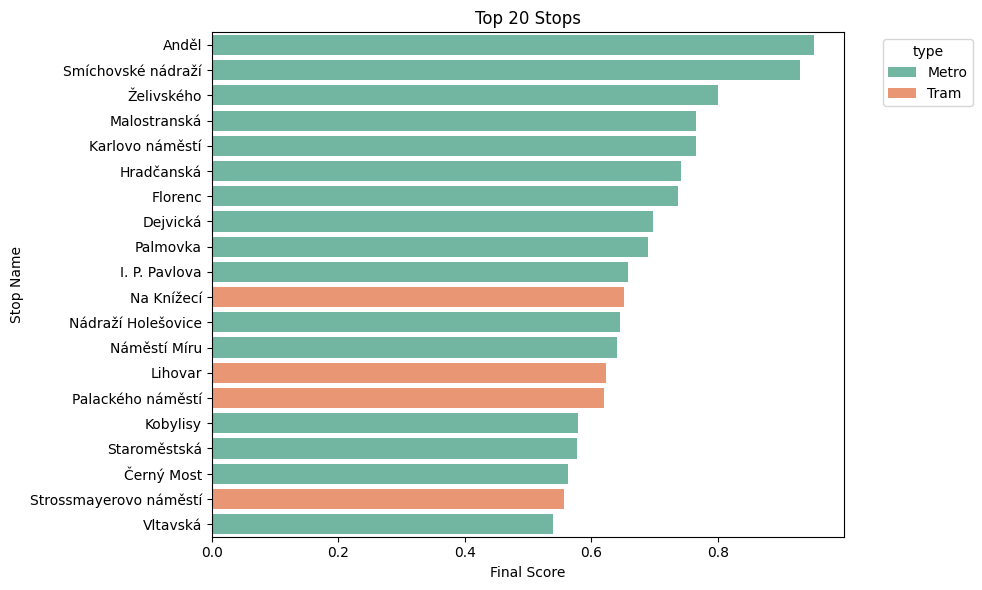

In [61]:
top_stops = best_stop.head(20)

plot_top(
    df=top_stops,
    x_col='final_score',
    y_col='stop_name',
    type_col='type',
    type_labels=type_labels,
    top_n=20,
    title='Top 20 Stops',
    figsize=(10,6),
    palette='Set2'
)

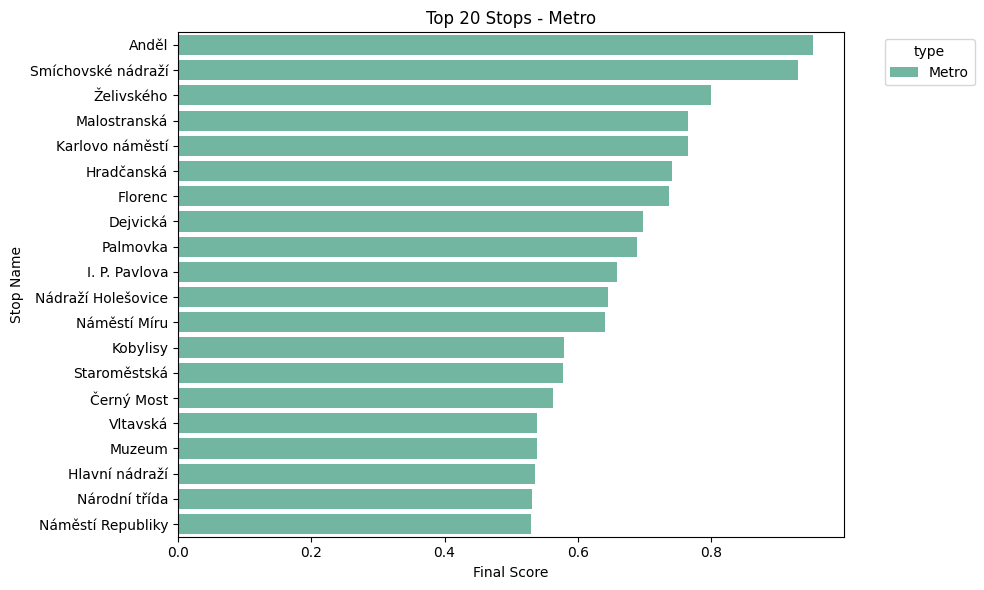

In [62]:
top_metro = best_stop[best_stop['stop_name'].isin(metro_stops)].head(20)

plot_top(
    df=top_metro,
    x_col='final_score',
    y_col='stop_name',
    type_col='type',
    type_labels=type_labels,
    top_n=20,
    title='Top 20 Stops - Metro',
    figsize=(10,6),
    palette='Set2'
)

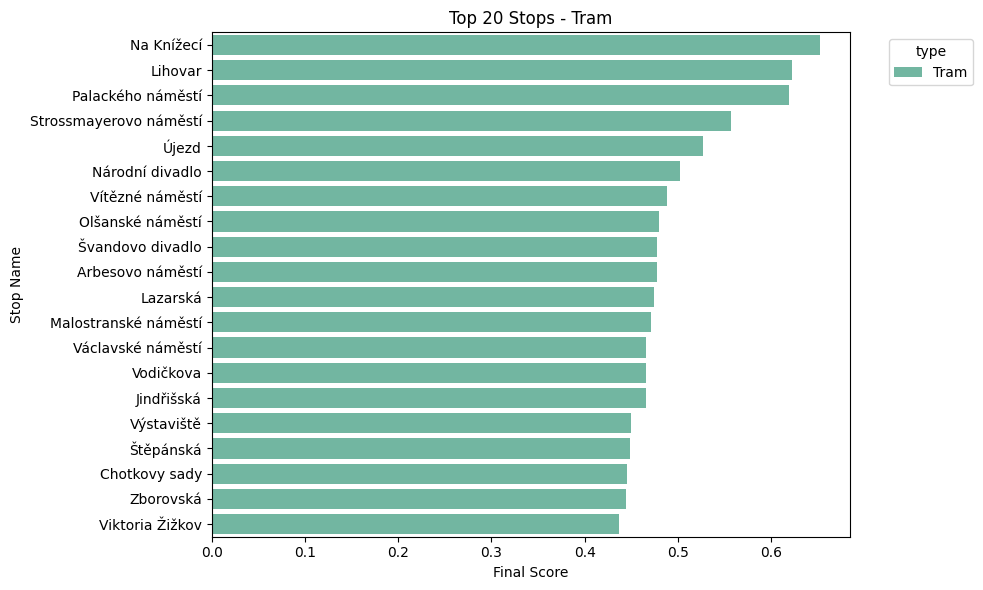

In [63]:
top_tram = best_stop[best_stop['stop_name'].isin(tram_stops)].head(20)

plot_top(
    df=top_tram,
    x_col='final_score',
    y_col='stop_name',
    type_col='type',
    type_labels=type_labels,
    top_n=20,
    title='Top 20 Stops - Tram',
    figsize=(10,6),
    palette='Set2'
)

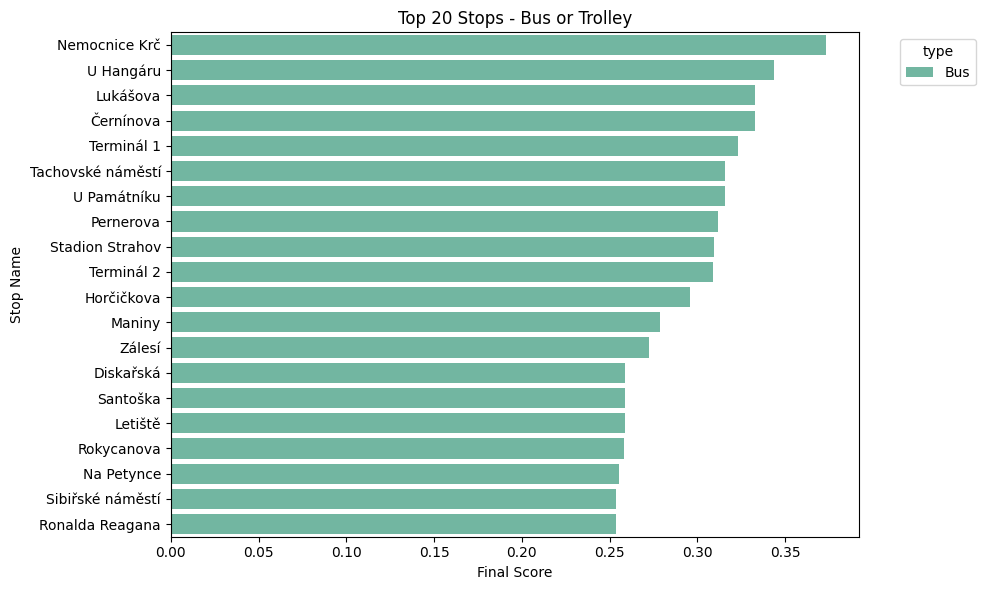

In [64]:
top_bus = best_stop[best_stop['stop_name'].isin(bus_stops + trolley_stops)].head(20)

plot_top(
    df=top_bus,
    x_col='final_score',
    y_col='stop_name',
    type_col='type',
    type_labels=type_labels,
    top_n=20,
    title='Top 20 Stops - Bus or Trolley',
    figsize=(10,6),
    palette='Set2'
)

## BEST ROUTE

Uses longest exposure + connects highly visited location - high repetition

Calculated using the following formula:

$$ final.score = w_{duration} \cdot duration + w_{numstops} \cdot num.stops + w_{connection} \cdot connection - w_{repetition} \cdot repetition $$



In [65]:
class RouteScorer:

    def __init__(
        self,
        avg_duration_per_route,
        avg_stops_per_route,
        connected_routes,
        high_repetition,
        routes_df
    ):
        self.avg_duration_per_route = avg_duration_per_route
        self.avg_stops_per_route = avg_stops_per_route
        self.connected_routes = set(connected_routes)
        self.high_repetition = high_repetition
        self.routes_df = routes_df

        # initializing the best_route df
        self.best_route = None

    def normalize_column(self, series):

       # normalizing a pd series
        min_val = series.min()
        max_val = series.max()
        if max_val - min_val == 0:
            return series * 0  # avoid division by zero
        return (series - min_val) / (max_val - min_val)

    def compute_scores(self):
        # computing normalized metrics and merging into best_route df

        self.best_route = self.avg_duration_per_route[["route_id", "route_short_name"]].copy()

        # normalizeing avg duration
        self.best_route["duration"] = self.normalize_column(self.avg_duration_per_route['duration_minutes'])

        # normalizing number of stops
        self.best_route["num_stops"] = self.normalize_column(self.avg_stops_per_route['num_stops'])

        # good location dummy
        self.best_route["good_loc"] = self.best_route['route_id'].isin(self.connected_routes).astype(int)

        # normalizing high repetition
        self.best_route["repetition"] = self.normalize_column(self.high_repetition['trip_count'])

        # merging route type
        self.best_route = self.best_route.merge(
            self.routes_df[["route_id", "route_type"]],
            on="route_id",
            how="left"
        )

        return self.best_route

In [66]:
scorer = RouteScorer(
    avg_duration_per_route=avg_duration_routes,
    avg_stops_per_route=avg_stops_per_route,
    connected_routes=connected_routes,
    high_repetition=high_repetition,
    routes_df=routes_df
)

best_route_df = scorer.compute_scores()
best_route_df.head(10)

,route_id,route_short_name,duration,num_stops,good_loc,repetition,route_type
0,L911,911,1.000000,1.000000,1,1.000000,3
1,L910,910,0.946667,0.965517,1,0.595335,3
2,L95,95,0.933333,0.896552,1,0.564431,0
3,L136,136,0.906667,0.862069,1,0.555685,3
4,L908,908,0.893333,0.844828,1,0.466472,3
5,L913,913,0.893333,0.827586,1,0.448980,3
6,L904,904,0.880000,0.810345,1,0.435569,3
7,L166,166,0.853333,0.775862,0,0.417493,3
8,L907,907,0.840000,0.758621,1,0.414577,3
9,L97,97,0.826667,0.758621,1,0.412245,0


In [67]:
def compute_final_route_score(
    best_route_df,
    w_duration=0.4,
    w_numstops=0.35,
    w_connection=0.1,
    w_repetition=0.15
):


    df = best_route_df.copy()

    # computing weighted final score
    df['final_score'] = (
        w_duration * df['duration'] +
        w_numstops * df['num_stops'] +
        w_connection * df['good_loc'] -
        w_repetition * df['repetition']
    )

    # sorting descending
    df = df.sort_values('final_score', ascending=False).reset_index(drop=True)

    return df

In [68]:
best_route = compute_final_route_score(
    best_route_df,
    w_duration=0.4,
    w_numstops=0.35,
    w_connection=0.1,
    w_repetition=0.15
)

best_route.head(10)

,route_id,route_short_name,duration,num_stops,good_loc,repetition,route_type,final_score
0,L910,910,0.946667,0.965517,1,0.595335,3,0.727297
1,L95,95,0.933333,0.896552,1,0.564431,0,0.702462
2,L911,911,1.000000,1.000000,1,1.000000,3,0.700000
3,L908,908,0.893333,0.844828,1,0.466472,3,0.683052
4,L136,136,0.906667,0.862069,1,0.555685,3,0.681038
5,L913,913,0.893333,0.827586,1,0.448980,3,0.679642
6,L904,904,0.880000,0.810345,1,0.435569,3,0.670285
7,L907,907,0.840000,0.758621,1,0.414577,3,0.639331
8,L97,97,0.826667,0.758621,1,0.412245,0,0.634347
9,L98,98,0.786667,0.741379,1,0.386006,0,0.616249


In [69]:
type_labels_route = {
    1: "Metro",
    0: "Tram",
    3: "Bus",
    11: "Trolley",
    2: "Train",
    4: "Ferry"
}

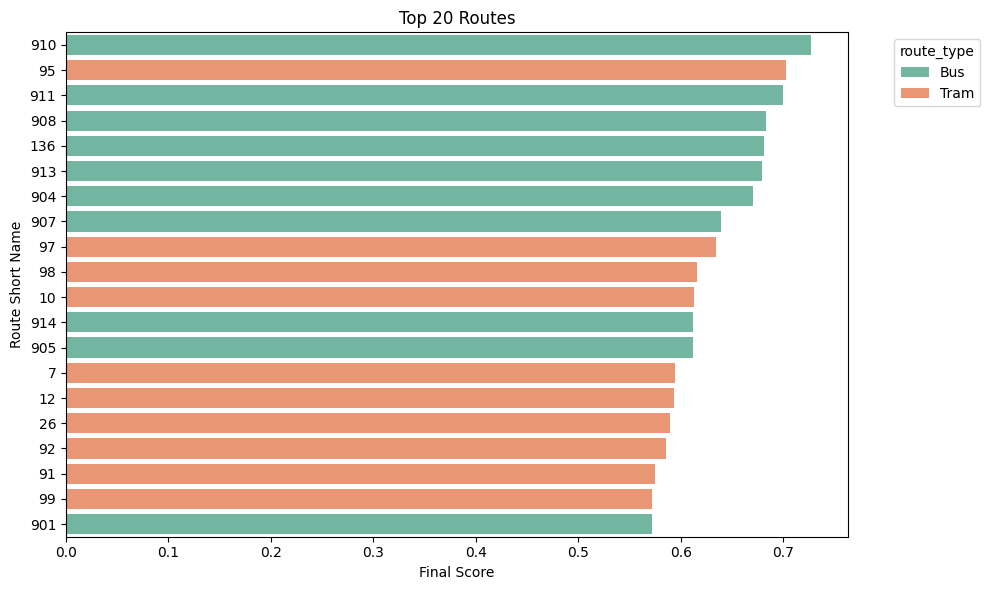

In [70]:
top_routes = best_route.head(20)

plot_top(
    df=top_routes,
    x_col='final_score',
    y_col='route_short_name',
    type_col='route_type',
    type_labels=type_labels_route,
    top_n=20,
    title='Top 20 Routes',
    figsize=(10,6),
    palette='Set2'
)

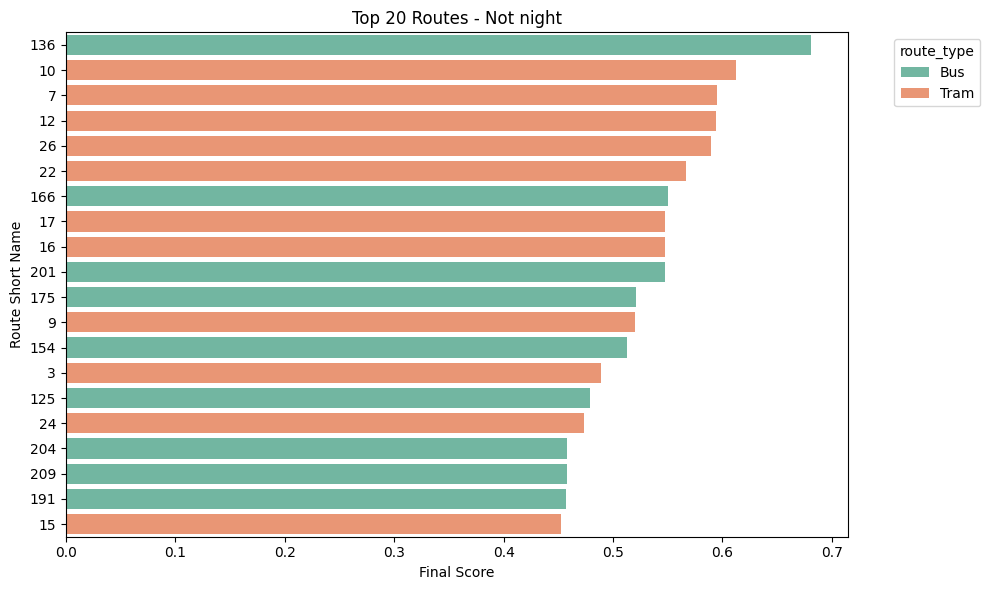

In [71]:
is_day = routes_df.loc[routes_df['is_night'] == 0, 'route_short_name'].tolist()
top_day = best_route[best_route['route_short_name'].isin(is_day)].head(20)

plot_top(
    df=top_day,
    x_col='final_score',
    y_col='route_short_name',
    type_col='route_type',
    type_labels=type_labels_route,
    top_n=20,
    title='Top 20 Routes - Not night',
    figsize=(10,6),
    palette='Set2'
)

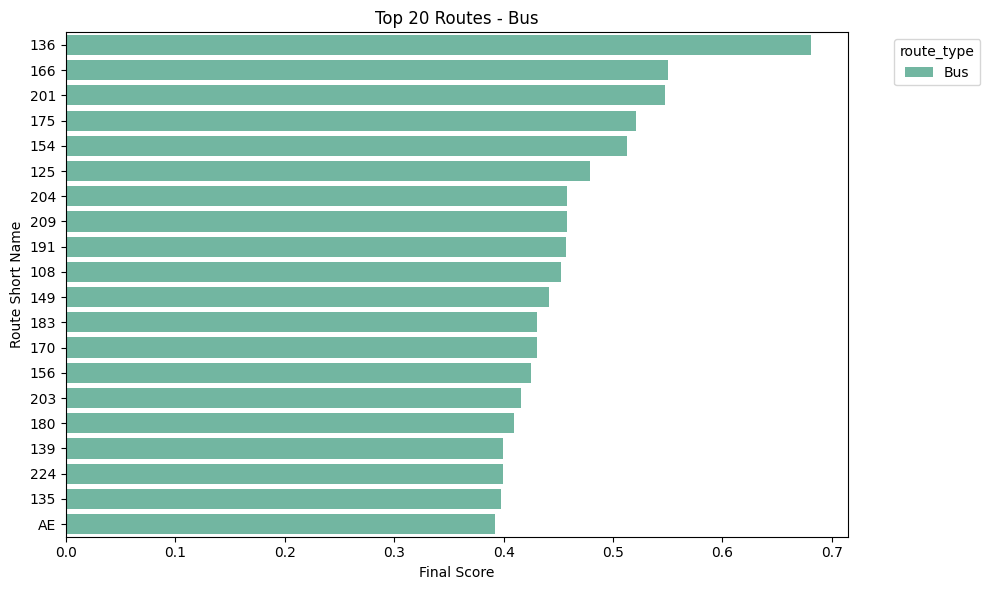

In [72]:
top_bus = best_route[best_route['route_type'] == 3]
top_bus = top_bus[top_bus['route_short_name'].isin(is_day)].head(20)

plot_top(
    df=top_bus,
    x_col='final_score',
    y_col='route_short_name',
    type_col='route_type',
    type_labels=type_labels_route,
    top_n=20,
    title='Top 20 Routes - Bus',
    figsize=(10,6),
    palette='Set2'
)

## TESTS

### HIGH VISIBILITY

In [73]:
def test_compute_high_visibility():
    stop_times_test = pd.DataFrame({
        'stop_id': [1, 1, 2, 3, 3, 3],
        'trip_id': ['a','b','c','d','e','f']})   
    stops_test = pd.DataFrame({
        'stop_id': [1, 2, 3],
        'stop_name': ['StopA', 'StopB', 'StopC']})
    
    result = compute_high_visibility(stop_times_test, stops_test)
    
    expected = pd.DataFrame({'stop_name': ['StopC', 'StopA', 'StopB'], 'trip_id': [3, 2, 1]})
    
    pd.testing.assert_frame_equal(result.reset_index(drop=True), expected)
    
    print("test_compute_high_visibility PASSED")

test_compute_high_visibility()

test_compute_high_visibility PASSED


### LONGEST EXPOSURE


In [74]:
def test_compute_avg_duration_per_route():
    stop_times_test = pd.DataFrame({
        'trip_id': ['t1', 't1', 't2', 't2'],
        'arrival_time': ['08:00:00', '08:30:00', '09:00:00', '09:20:00']})
    trips_test = pd.DataFrame({
        'trip_id': ['t1', 't2'],
        'route_id': ['r1', 'r2']})
    routes_test = pd.DataFrame({
        'route_id': ['r1', 'r2'],
        'route_short_name': ['A', 'B'],
        'is_regional': [0, 1] })

    analyzer = RouteDurationAnalyzer(stop_times_test, trips_test, routes_test)
    result = analyzer.compute_avg_duration_per_route(exclude_regional=True)

    expected = pd.DataFrame({
        'route_id': ['r1'],
        'route_short_name': ['A'],
        'is_regional': [0],
        'duration_seconds': [1800.0],
        'duration_minutes': [30.0]
    })

    assert list(result.columns) == [
        'route_id',
        'route_short_name',
        'is_regional',
        'duration_seconds',
        'duration_minutes'
    ]

    pd.testing.assert_frame_equal(result.reset_index(drop=True), expected)

    print("test_compute_avg_duration_per_route PASSED")

test_compute_avg_duration_per_route()

test_compute_avg_duration_per_route PASSED


In [75]:
def test_compute_avg_stops_per_route():
    stop_times_test = pd.DataFrame({
        'trip_id': ['t1', 't1', 't2', 't2', 't3', 't3', 't3'],
        'stop_id': ['s1', 's2', 's3', 's4', 's5', 's6', 's7']})
    trips_test = pd.DataFrame({
        'trip_id': ['t1', 't2', 't3'],
        'route_id': ['r1', 'r2', 'r3']})
    routes_test = pd.DataFrame({
        'route_id': ['r1', 'r2', 'r3'],
        'route_short_name': ['A', 'B', 'C'],
        'is_regional': [0, 1, 0] })

    avg_stops = compute_avg_stops_per_route(stop_times_test, trips_test, routes_test, exclude_regional=True)

    expected_num_stops = {'r3': 3.0, 'r1': 2.0}
    expected_routes = ['r3', 'r1']

    assert list(avg_stops['route_id']) == expected_routes, f"Expected route IDs {expected_routes}, got {list(avg_stops['route_id'])}"

    for _, row in avg_stops.iterrows():
        assert row['num_stops'] == expected_num_stops[row['route_id']], f"For route {row['route_id']}, expected {expected_num_stops[row['route_id']]}, got {row['num_stops']}"

    print("test_compute_avg_stops_per_route PASSED")

test_compute_avg_stops_per_route()

test_compute_avg_stops_per_route PASSED


### HIGHEST REPETITION


In [76]:
def test_compute_route_repetition():
    trips_test = pd.DataFrame({
        'trip_id': ['t1', 't2', 't3', 't4'],
        'route_id': ['r1', 'r1', 'r2', 'r3']})
    routes_test = pd.DataFrame({
        'route_id': ['r1', 'r2', 'r3'],
        'route_short_name': ['A', 'B', 'C'],
        'is_regional': [0, 1, 0]})

    result = compute_route_repetition(
        trips_test,
        routes_test,
        exclude_regional=True)

    expected = pd.DataFrame({
        'route_id': ['r1', 'r3'],
        'route_short_name': ['A', 'C'],
        'is_regional': [0, 0],
        'trip_count': [2, 1]})

    pd.testing.assert_frame_equal(
        result.reset_index(drop=True),
        expected
    )

    print("test_compute_route_repetition PASSED")

test_compute_route_repetition()

test_compute_route_repetition PASSED


### HIGHLY VISITED LOCATIONS

In [77]:
def test_get_stops_in_buffers():
    stops_test = pd.DataFrame({
        'stop_id': ['s1', 's2', 's3', 's4'],
        'stop_lat': [50.0, 50.01, 50.02, 50.03],
        'stop_lon': [14.0, 14.0, 14.01, 14.02]
    })
    
    main_loc = (14.0, 50.0)

    other_locs_df = pd.DataFrame({
        'name': ['Loc1'],
        'lon': [14.01],
        'lat': [50.02]
    })

    stops_near = get_stops_in_buffers(
        stops_test,
        main_loc=main_loc,
        main_buffer_m=2000,
        other_locs_df=other_locs_df,
        other_buffer_m=500
    )

    expected_ids = set(['s1', 's2', 's3'])

    result_ids = set(stops_near['stop_id'])
    assert result_ids == expected_ids, f"Expected {expected_ids}, got {result_ids}"

    assert stops_near['stop_id'].duplicated().sum() == 0, "Duplicate stops found"

    print("test_get_stops_in_buffers PASSED")

test_get_stops_in_buffers()

test_get_stops_in_buffers PASSED


In [78]:
def test_get_routes_connected_to_stops():
    stop_times_test = pd.DataFrame({
        'trip_id': ['t1', 't1', 't2', 't3', 't3'],
        'stop_id': ['s1', 's2', 's3', 's4', 's5']})
    trips_test = pd.DataFrame({
        'trip_id': ['t1', 't2', 't3'],
        'route_id': ['r1', 'r2', 'r3']})
    routes_test = pd.DataFrame({
        'route_id': ['r1', 'r2', 'r3'],
        'route_short_name': ['A', 'B', 'C'],
        'is_regional': [0, 1, 0] })

    stops_filter_test = pd.DataFrame({
        'stop_id': ['s1', 's4']})

    stops_per_route, connected_routes = get_routes_connected_to_stops(
        stop_times_test,
        trips_test,
        routes_test,
        stops_filter_test,
        exclude_regional=True
    )


    expected_routes = set(['r1', 'r3'])
    assert connected_routes == expected_routes, f"Expected {expected_routes}, got {connected_routes}"

    expected_stops = {
        'r1': ['s1'],
        'r3': ['s4']
    }
    for _, row in stops_per_route.iterrows():
        route_id = row['route_id']
        stops = row['stop_id']
        assert stops == expected_stops[route_id], f"For route {route_id}, expected stops {expected_stops[route_id]}, got {stops}"

    print("test_get_routes_connected_to_stops PASSED")

test_get_routes_connected_to_stops()

test_get_routes_connected_to_stops PASSED
